In [92]:
######################################
# Developed by Baptiste PICARD       #
# picard.baptiste@laposte.net        #
# Started the 21th of April 2020     #
# Updated the 26th of August 2023    #
# Resume :                           #
# Evolution of the prices.           # 
# Model to predict the evolutions    #
#                                    #
######################################

# Utils
import os
import json
import random
import subprocess
import time 
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pre-processing 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, max_error

# Models : Regression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet


# Environment
plt.style.use('seaborn') # Change the style of the figures.
pd.set_option('display.max_columns', 50)

# Constants 
train_set = './data/sales_train.csv'
test_set = './data/test.csv'
subs_set = './data/sample_submission.csv'
items = './data/items.csv'
categories = './data/item_categories.csv'
shops = './data/shops.csv'

ModuleNotFoundError: No module named 'fbprophet'

In [94]:
!pip --version

pip 20.0.2 from D:\Logiciel\Progra\Anaconda\lib\site-packages\pip (python 3.6)



In [2]:
# Open the .csv file  
df_train_set = pd.read_csv(train_set, parse_dates=["date"]) # Training
df_test_set = pd.read_csv(test_set) # Test
df_subs_set = pd.read_csv(subs_set) # Sample submission
df_shops_set = pd.read_csv(shops) # Shops
df_items_set = pd.read_csv(items) # Items
df_categories_set = pd.read_csv(categories) # Categories

print(f"Train/Initial shape: {df_train_set.shape}.")
print(f"Test/Initial shape: {df_train_set.shape}.")
print(f"Sub/Initial shape: {df_train_set.shape}.")

Train/Initial shape: (2935849, 6).
Test/Initial shape: (2935849, 6).
Sub/Initial shape: (2935849, 6).


In [3]:
df_train_set.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [4]:
df_test_set.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
df_subs_set.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [12]:
# Creating the df_train 
df_train_shop = pd.merge(df_train_set, df_shops_set, on='shop_id', how='inner')
df_train_shop_item = pd.merge(df_train_shop, df_items_set, on='item_id', how='inner')
df_train = pd.merge(df_train_shop_item, df_categories_set, on='item_category_id', how='inner')
# df_train = df_train.drop(['shop_id', 'item_id', 'item_category_id'], axis=1)

# Creating the df_test / df_subs
df_test_shop = pd.merge(df_test_set, df_shops_set, on='shop_id', how='inner')
df_test_shop_items = pd.merge(df_test_shop, df_items_set, on='item_id', how='inner')
df_test = pd.merge(df_test_shop_items, df_categories_set, on='item_category_id', how='inner')
# df_test = df_test.drop(['shop_id', 'item_id', 'item_category_id'], axis=1)

# Train 
df_train_rows, df_train_columns = df_train.shape

# Test 
df_test_rows, df_test_columns = df_test.shape
print('Train set : \n train.csv : {} (rows/columns).'.format(df_train.shape))
print('Test set : \n test.csv : {} (rows/columns).'.format(df_test.shape))
print('Total nan values (train) : {}'.format(df_train.isnull().sum().sum()))
print('Total nan values (test) : {}'.format(df_test.isnull().sum().sum()))
df_train = (
    df_train
    .rename(
        columns={
            'shop_name': 'shop_name (RUSSIA)',
            'item_name': 'item_name (RUSSIA)',
            'item_category_name': 'item_category_name (RUSSIA)',
        }
    )
)
df_test = (
    df_test
    .rename(
        columns={
            'shop_name': 'shop_name (RUSSIA)',
            'item_name': 'item_name (RUSSIA)',
            'item_category_name': 'item_category_name (RUSSIA)',
        }
    )
)
print(f"Final shape: {df_train_set.shape}.")

Train set : 
 train.csv : (2935849, 10) (rows/columns).
Test set : 
 test.csv : (214200, 7) (rows/columns).
Total nan values (train) : 0
Total nan values (test) : 0
Final shape: (2935849, 6).


In [21]:
df_train.sort_values(by=["date"], ascending=False).head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name (RUSSIA),item_name (RUSSIA),item_category_id,item_category_name (RUSSIA)
2889454,2015-12-10,33,19,13277,359.0,1.0,"Курск ТЦ ""Пушкинский""",Комикс Молодые Мстители Том 1 Стиль важнее сути,47,"Книги - Комиксы, манга"
1679694,2015-12-10,33,10,17011,450.0,1.0,Жуковский ул. Чкалова 39м?,ПИКНИК Большая игра 3CD (фирм),55,Музыка - CD локального производства
1984639,2015-12-10,33,31,6497,1499.0,1.0,"Москва ТЦ ""Семеновский""","Sims 3: Набор для новичков [PC, русская версия]",28,Игры PC - Дополнительные издания
2371806,2015-12-10,33,42,18187,299.0,1.0,"СПб ТК ""Невский Центр""",СБ. 100 Blues Ballads (mp3-CD) (jewel),57,Музыка - MP3
2826263,2015-12-10,33,14,1971,3598.0,2.0,"Казань ТЦ ""ПаркХаус"" II",Bloodborne: Порождение крови. Коллекционное из...,20,Игры - PS4


In [14]:
df_test.head()

,ID,shop_id,item_id,shop_name (RUSSIA),item_name (RUSSIA),item_category_id,item_category_name (RUSSIA)
0,0,5,5037,"Вологда ТРЦ ""Мармелад""","NHL 15 [PS3, русские субтитры]",19,Игры - PS3
1,5100,4,5037,"Волжский ТЦ ""Волга Молл""","NHL 15 [PS3, русские субтитры]",19,Игры - PS3
2,10200,6,5037,"Воронеж (Плехановская, 13)","NHL 15 [PS3, русские субтитры]",19,Игры - PS3
3,15300,3,5037,"Балашиха ТРК ""Октябрь-Киномир""","NHL 15 [PS3, русские субтитры]",19,Игры - PS3
4,20400,2,5037,"Адыгея ТЦ ""Мега""","NHL 15 [PS3, русские субтитры]",19,Игры - PS3


### Pick a random item

In [41]:
shop = 'Курск ТЦ "Пушкинский"'
item = "Sims 3: Набор для новичков [PC, русская версия]"
shop_selection = (df_train["shop_name (RUSSIA)"] == shop)
item_selection = (df_train["item_name (RUSSIA)"] == item)

example_df = (
    df_train[shop_selection & item_selection]
    .groupby("date_block_num")
    .agg({
        "item_cnt_day": "sum",
        "item_price": "mean",
    })
    .sort_values(by=["date_block_num"])
    .reset_index()
    .rename(
        columns={
            "item_cnt_day": "item_cnt_mth",
            "item_price": "item_price_mean",
        }
    )
)
print(f"There are {example_df.shape} items for the example.")
example_df

There are (26, 3) items for the example.


,date_block_num,item_cnt_mth,item_price_mean
0,5,3.0,999.000000
1,6,2.0,999.000000
2,8,1.0,999.000000
3,9,2.0,999.000000
4,10,3.0,999.000000
5,11,2.0,999.000000
6,12,3.0,749.250000
7,13,3.0,587.750000
8,14,6.0,741.333333
9,15,3.0,899.000000


<AxesSubplot:title={'center':'Visualization the price evolution for item: Sims 3: Набор для новичков [PC, русская версия] for the shop; Курск ТЦ "Пушкинский".'}, xlabel='date_block_num', ylabel='item_price_mean'>

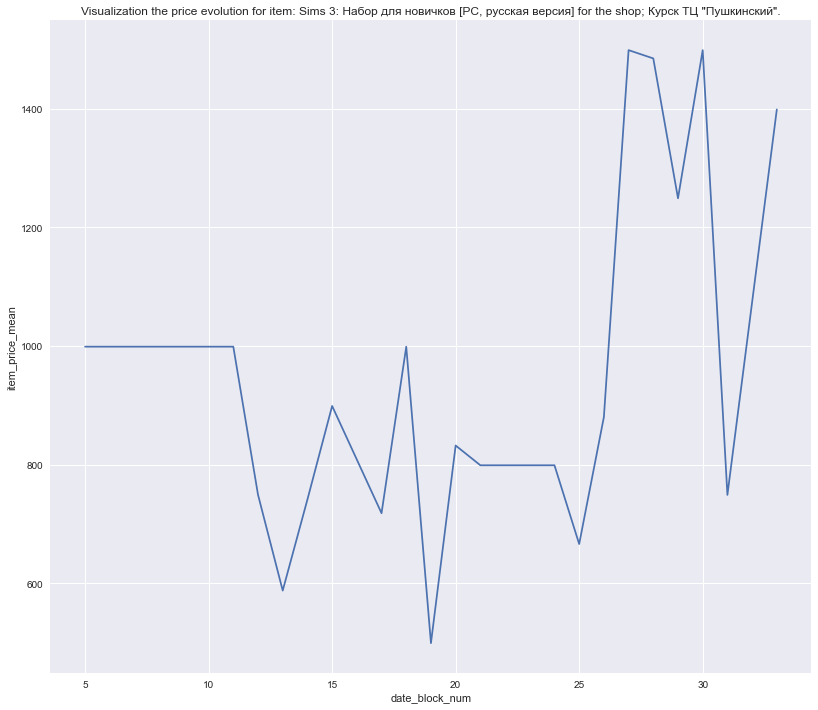

In [42]:
plt.figure(figsize=(30,12))
plt.subplot(121)
plt.title(f"Visualization the price evolution for item: {item} for the shop; {shop}.")
plt.xlabel('Date')
plt.ylabel('Price')
sns.lineplot(data=example_df, x="date_block_num", y="item_price_mean")

<AxesSubplot:title={'center':'Visualization the price evolution for item: Sims 3: Набор для новичков [PC, русская версия] for the shop; Курск ТЦ "Пушкинский".'}, xlabel='date_block_num', ylabel='item_cnt_mth'>

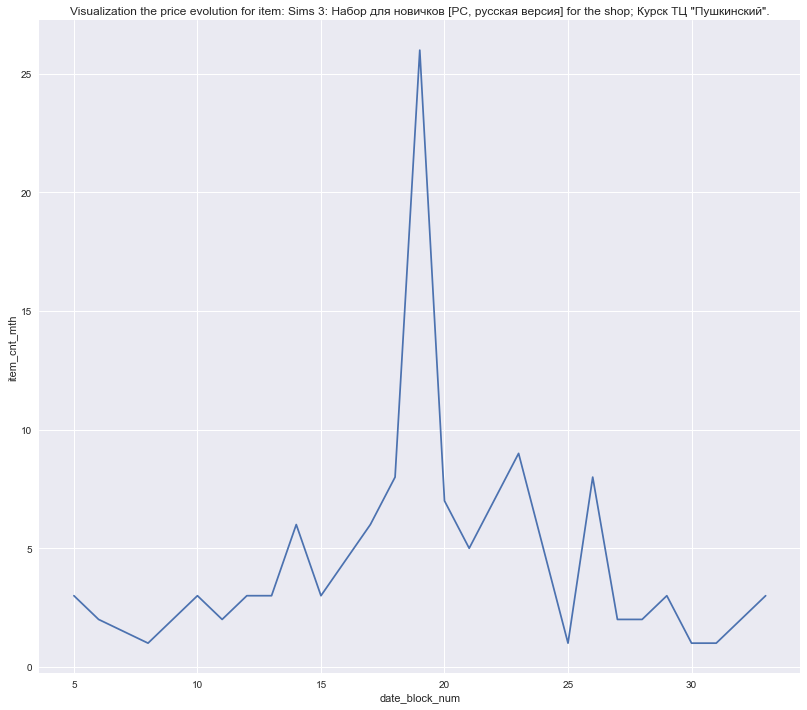

In [43]:
plt.figure(figsize=(30,12))
plt.subplot(121)
plt.title(f"Visualization the price evolution for item: {item} for the shop; {shop}.")
plt.xlabel('Date')
plt.ylabel('item_cnt_day')
sns.lineplot(data=example_df, x="date_block_num", y="item_cnt_mth")

### Test ARIMA

In [83]:
# fill date_block
max_date_block_num = example_df["date_block_num"].max()
new_index = range(max_date_block_num + 1)
mean_item_cnt_mth = example_df["item_cnt_mth"].max()
example_df_arima = example_df.set_index("date_block_num").reindex(new_index).reset_index()
example_df_arima["item_cnt_mth"] = example_df_arima["item_cnt_mth"].fillna(mean_item_cnt_mth)
example_df_arima

,date_block_num,item_cnt_mth,item_price_mean
0,0,26.0,NaN
1,1,26.0,NaN
2,2,26.0,NaN
3,3,26.0,NaN
4,4,26.0,NaN
5,5,3.0,999.000000
6,6,2.0,999.000000
7,7,26.0,NaN
8,8,1.0,999.000000
9,9,2.0,999.000000


In [84]:
# model
model = ARIMA(example_df_arima.item_cnt_mth.values, order=(5, 0, 0))
model_fit = model.fit()
# predict
predicted_values = model_fit.predict(start=33, end=38, exog=None, dynamic=False)

In [85]:
predicted_values

array([10.06637664,  9.16132468, 17.78285307,  9.68093275,  8.51962793,
       14.50127866])

In [86]:
new_index = range(max_date_block_num + 1 + len(predicted_values))
example_df_arima = example_df.set_index("date_block_num").reindex(new_index).reset_index()
# example_df_arima["predicted_values"] = np.nan
example_df_arima["item_cnt_mth"][-6:] = predicted_values
example_df_arima

D:\Logiciel\Progra\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,date_block_num,item_cnt_mth,item_price_mean
0,0,NaN,NaN
1,1,NaN,NaN
2,2,NaN,NaN
3,3,NaN,NaN
4,4,NaN,NaN
5,5,3.000000,999.000000
6,6,2.000000,999.000000
7,7,NaN,NaN
8,8,1.000000,999.000000
9,9,2.000000,999.000000


<AxesSubplot:title={'center':'Visualization the price evolution for item: Sims 3: Набор для новичков [PC, русская версия] for the shop; Курск ТЦ "Пушкинский".'}, xlabel='date_block_num', ylabel='item_cnt_mth'>

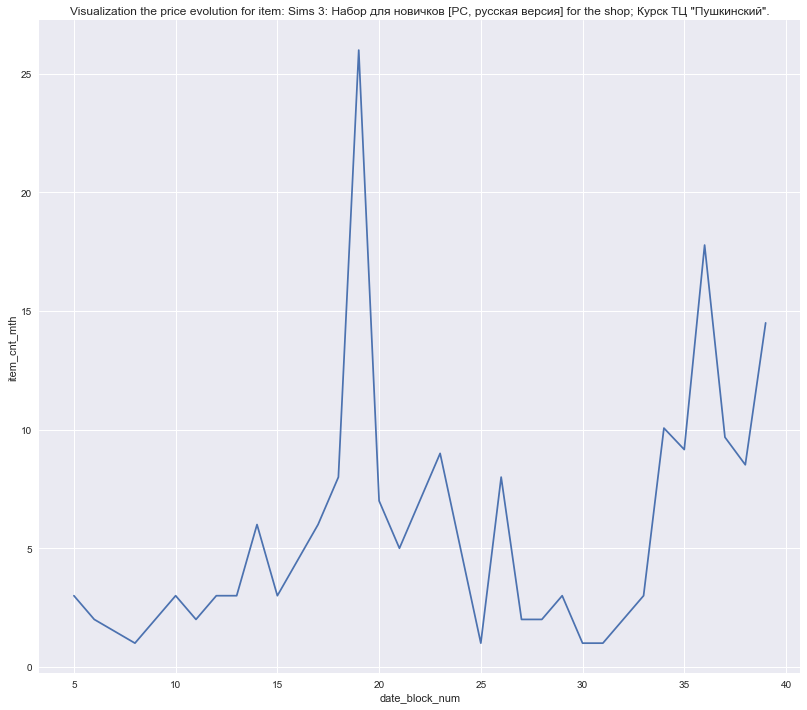

In [87]:
plt.figure(figsize=(30,12))
plt.subplot(121)
plt.title(f"Visualization the price evolution for item: {item} for the shop; {shop}.")
plt.xlabel('Date')
plt.ylabel('Price')
sns.lineplot(data=example_df_arima, x="date_block_num", y="item_cnt_mth")

### SARIMAX

In [88]:
# fill date_block
max_date_block_num = example_df["date_block_num"].max()
new_index = range(max_date_block_num + 1)
mean_item_cnt_mth = example_df["item_cnt_mth"].max()
example_df_sarimax = example_df.set_index("date_block_num").reindex(new_index).reset_index()
example_df_sarimax["item_cnt_mth"] = example_df_sarimax["item_cnt_mth"].fillna(mean_item_cnt_mth)
example_df_sarimax

,date_block_num,item_cnt_mth,item_price_mean
0,0,26.0,NaN
1,1,26.0,NaN
2,2,26.0,NaN
3,3,26.0,NaN
4,4,26.0,NaN
5,5,3.0,999.000000
6,6,2.0,999.000000
7,7,26.0,NaN
8,8,1.0,999.000000
9,9,2.0,999.000000


In [89]:
# model
model = SARIMAX(example_df_arima.item_cnt_mth.values, order=(5, 0, 0))
model_fit = model.fit()
# predict
predicted_values = model_fit.predict(start=33, end=38, exog=None, dynamic=False)

In [90]:
new_index = range(max_date_block_num + 1 + len(predicted_values))
example_df_sarimax = example_df.set_index("date_block_num").reindex(new_index).reset_index()
# example_df_arima["predicted_values"] = np.nan
example_df_sarimax["item_cnt_mth"][-6:] = predicted_values
example_df_sarimax

D:\Logiciel\Progra\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,date_block_num,item_cnt_mth,item_price_mean
0,0,NaN,NaN
1,1,NaN,NaN
2,2,NaN,NaN
3,3,NaN,NaN
4,4,NaN,NaN
5,5,3.000000,999.000000
6,6,2.000000,999.000000
7,7,NaN,NaN
8,8,1.000000,999.000000
9,9,2.000000,999.000000


<AxesSubplot:title={'center':'Visualization the price evolution for item: Sims 3: Набор для новичков [PC, русская версия] for the shop; Курск ТЦ "Пушкинский".'}, xlabel='date_block_num', ylabel='item_cnt_mth'>

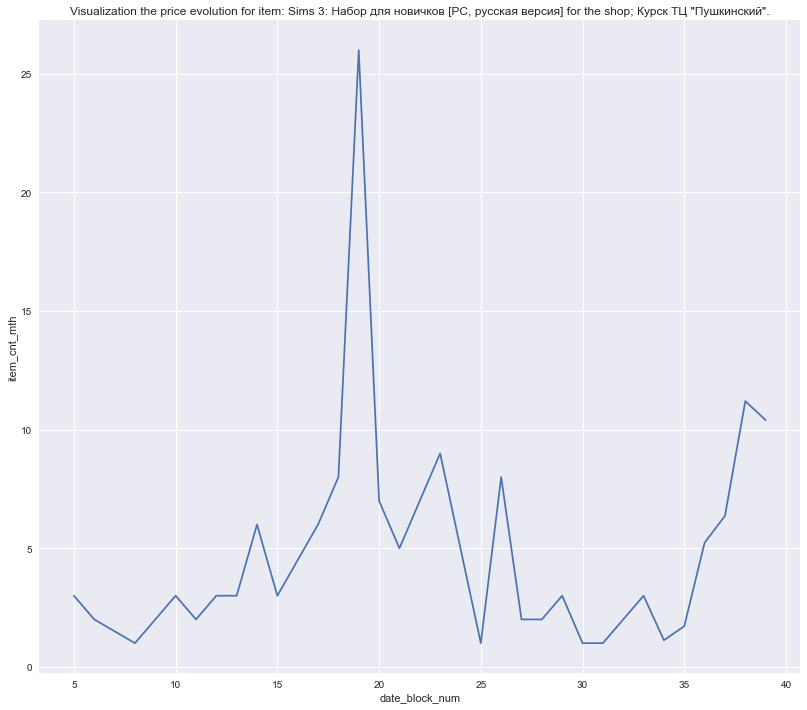

In [91]:
plt.figure(figsize=(30,12))
plt.subplot(121)
plt.title(f"Visualization the price evolution for item: {item} for the shop; {shop}.")
plt.xlabel('Date')
plt.ylabel('Price')
sns.lineplot(data=example_df_sarimax, x="date_block_num", y="item_cnt_mth")

### Create date column

In [92]:
df_train["year"] = df_train["date"].dt.year
df_train["month"] = df_train["date"].dt.month
df_train["day"] = df_train["date"].dt.day
df_train["weekday"] = df_train["date"].dt.weekday
df_train["week"] = df_train["date"].apply(lambda x: x.weekofyear)
df_train

,date,date_block_num,item_price,item_cnt_day,shop_name (RUSSIA),item_name (RUSSIA),item_category_name (RUSSIA),year,month,day,weekday,week
0,2013-02-01,0,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,2,1,4,5
1,2013-02-01,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,2,1,4,5
2,2013-03-01,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,3,1,4,9
3,2013-01-20,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,20,6,3
4,2013-01-23,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,23,2,4
5,2013-01-26,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,26,5,4
6,2015-08-27,31,299.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2015,8,27,3,35
7,2015-02-09,32,299.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2015,2,9,0,7
8,2013-01-23,0,999.0,1.0,"Москва ТК ""Буденовский"" (пав.К7)",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,23,2,4
9,2015-10-10,33,299.0,1.0,"Москва ТК ""Буденовский"" (пав.К7)",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2015,10,10,5,41


### Item category

In [93]:
items = {        
        # Cinema
        'Кино - Blu-Ray' : {'field' : 'Cinema', 'category' : 'Blu-ray'},
        'Кино - DVD' : {'field' : 'Cinema', 'category' : 'DVD'},        
        'Кино - Blu-Ray 3D' : {'field' : 'Cinema', 'category' : 'Blu-Ray 3D'},
        'Кино - Коллекционное' : {'field' : 'Cinema', 'category' : 'Collection'}, 
        'Кино - Blu-Ray 4K' : {'field' : 'Cinema', 'category' : 'Blu-Ray 4K'}, 

    
        # Accessories
        'Аксессуары - PSVita' : {'field' : 'Accessories', 'category' : 'PSVita'},
        'Аксессуары - PS3' : {'field' : 'Accessories', 'category' : 'PS3'},
        'Аксессуары - XBOX 360' : {'field' : 'Accessories', 'category' : 'XBOX 360'},
        'Аксессуары - PSP' : {'field' : 'Accessories', 'category' : 'PSP'},
        'Аксессуары - PS4' : {'field' : 'Accessories', 'category' : 'PS4'},
        'Аксессуары - XBOX ONE' : {'field' : 'Accessories', 'category' : 'XBOX ONE'},
        'PC - Гарнитуры/Наушники' : {'field' : 'Accessories', 'category' : 'Headphones'}, 
        'Аксессуары - PS2' : {'field' : 'Accessories', 'category' : 'PS2'},
        'Элементы питания' : {'field' : 'Accessories', 'category' : 'Battery'},
    
        # Music
        'Музыка - CD локального производства' : {'field' : 'Music', 'category' : 'CD'},
        'Музыка - Музыкальное видео' : {'field' : 'Music', 'category' : 'Clip video'},
        'Музыка - CD фирменного производства' : {'field' : 'Music', 'category' : 'CD'},
        'Музыка - MP3' : {'field' : 'Music', 'category' : 'MP3'}, 
        'Музыка - Подарочные издания' : {'field' : 'Music', 'category' : 'Gift Edition'},
        'Музыка - Винил' : {'field' : 'Music', 'category' : 'Vinyl'},
    
        # Games 
        'Игры - PSVita' : {'field' : 'Games', 'category' : 'PSVita'},
        'Игры - XBOX 360' : {'field' : 'Games', 'category' : 'XBOX 360'},
        'Игры - PSP' : {'field' : 'Games', 'category' : 'PSP'},
        'Игры PC - Стандартные издания' : {'field' : 'Games', 'category' : 'Pc Standard Editions'},
        'Игры - PS3' : {'field' : 'Games', 'category' : 'PS3'},
        'Игры PC - Дополнительные издания' : {'field' : 'Games', 'category' : 'Pc DLC'},
        'Игры PC - Коллекционные издания' : {'field' : 'Games', 'category' : 'Pc Collector'},
        'Игры - Аксессуары для игр' : {'field' : 'Games', 'category' : 'Accessories'},
        'Игры - PS4' : {'field' : 'Games', 'category' : 'PS4'}, 
        'Игры - XBOX ONE' : {'field' : 'Games', 'category' : 'XBOX ONE'}, 
        'Игры - PS2' : {'field' : 'Games', 'category' : 'PS2'},
        'Игры PC - Цифра' : {'field' : 'Games', 'category' : 'Digit'},
        'Игры Android - Цифра' : {'field' : 'Games', 'category' : 'Android'}, 
        'Игры MAC - Цифра' : {'field' : 'Games', 'category' : 'MAC'},
        
        # Gifts
        'Подарки - Гаджеты, роботы, спорт' : {'field' : 'Gifts', 'category' : 'Gadjet'},
        'Подарки - Мягкие игрушки' : {'field' : 'Gifts', 'category' : 'Toys'},        
        'Подарки - Сувениры' : {'field' : 'Gifts', 'category' : 'Souvenirs'},
        'Подарки - Настольные игры' : {'field' : 'Gifts', 'category' : 'Board games'},
        'Подарки - Настольные игры (компактные)' : {'field' : 'Gifts', 'category' : 'Board games'},
        'Подарки - Развитие' : {'field' : 'Gifts', 'category' : 'Développement'},
        'Подарки - Фигурки' : {'field' : 'Gifts', 'category' : 'Figurines'},
        'Подарки - Сувениры (в навеску)' : {'field' : 'Gifts', 'category' : 'Souvenirs'},
        'Подарки - Сумки, Альбомы, Коврики д/мыши' : {'field' : 'Gifts', 'category' : 'Bags, Albums, Mousepads'},
        'Подарки - Атрибутика' : {'field' : 'Gifts', 'category' : 'Attributes'},
        'Подарки - Открытки, наклейки' : {'field' : 'Gifts', 'category' : 'Postcards / Stickers'},
        'Подарки - Сертификаты, услуги' : {'field' : 'Gifts', 'category' : 'Certificates / Services'},
    
        # Payement Cards
        'Карты оплаты - PSN' : {'field' : 'Payement Cards', 'category' : 'PSN'},
        'Карты оплаты - Live!' : {'field' : 'Payement Cards', 'category' : 'Live!'},
        'Карты оплаты (Кино, Музыка, Игры)' : {'field' : 'Payement Cards', 'category' : 'Cinema / Music / Games'},
        'Карты оплаты - Live! (Цифра)' : {'field' : 'Payement Cards', 'category' : 'Live!'},
        'Карты оплаты - Windows (Цифра)' : {'field' : 'Payement Cards', 'category' : 'Windows'},
    
        # Programs
        'Программы - Для дома и офиса' : {'field' : 'Programs', 'category' : 'Home/Office'},
        'Программы - 1С:Предприятие 8' : {'field' : 'Programs', 'category' : 'Entreprise'},
        'Служебные' : {'field' : 'Programs', 'category' : 'Office'},
        'Программы - Обучающие' : {'field' : 'Programs', 'category' : 'Education'},
        'Программы - Для дома и офиса (Цифра)' : {'field' : 'Programs', 'category' : 'Home/Office'},
        'Программы - Обучающие (Цифра)' : {'field' : 'Programs', 'category' : 'Education'},
        'Программы - MAC (Цифра)' : {'field' : 'Programs', 'category' : 'MAC'},
    
        # Console
        'Игровые консоли - XBOX 360' : {'field' : 'Consoles', 'category' : 'XBOX 360'},
        'Игровые консоли - PSP' : {'field' : 'Consoles', 'category' : 'PSP'},  
        'Игровые консоли - PS3' : {'field' : 'Consoles', 'category' : 'PS3'},
        'Игровые консоли - PSVita' : {'field' : 'Consoles', 'category' : 'PSVita'},
        'Игровые консоли - Прочие' : {'field' : 'Consoles', 'category' : 'Other'}, 
        'Игровые консоли - XBOX ONE' : {'field' : 'Consoles', 'category' : 'XBOX ONE'},
        'Игровые консоли - PS4' : {'field' : 'Consoles', 'category' : 'PS4'},
        'Игровые консоли - PS2' : {'field' : 'Consoles', 'category' : 'PS2'},
    
        # Books
        'Книги - Методические материалы 1С' : {'field' : 'Books', 'category' : 'Methods'},
        'Книги - Аудиокниги' : {'field' : 'Books', 'category' : 'Audiobooks'},
        'Книги - Аудиокниги 1С' : {'field' : 'Books', 'category' : 'Audiobooks'},
        'Книги - Комиксы, манга' : {'field' : 'Books', 'category' : 'Manga / Comics'},
        'Книги - Артбуки, энциклопедии' : {'field' : 'Books', 'category' : 'Artbooks / Encyclopedias'},
        'Книги - Бизнес литература' : {'field' : 'Books', 'category' : 'Business Literature'},
        'Книги - Путеводители' : {'field' : 'Books', 'category' : 'Guides'},
        'Книги - Художественная литература' : {'field' : 'Books', 'category' : 'Fiction'},
        'Книги - Открытки' : {'field' : 'Books', 'category' : 'Postcards'},
        'Книги - Компьютерная литература' : {'field' : 'Books', 'category' : 'Computer literature'}, 
        'Книги - Познавательная литература' : {'field' : 'Books', 'category' : 'Education'}, 
        'Книги - Цифра' : {'field' : 'Books', 'category' : 'Digit'},
        'Книги - Аудиокниги (Цифра)' : {'field' : 'Books', 'category' : 'Audiobooks'},
    
        # Services
        'Билеты (Цифра)' : {'field' : 'Services', 'category' : 'Tickets'},
        'Служебные - Билеты' : {'field' : 'Services', 'category' : 'Tickets'},
        'Доставка товара' : {'field' : 'Services', 'category' : 'Delivery'},
    
        # Media
        'Чистые носители (штучные)' : {'field' : 'Media', 'category' : 'Piece'},
        'Чистые носители (шпиль)' : {'field' : 'Media', 'category' : 'Spire'},
}
df_train["item_field"] = df_train["item_category_name (RUSSIA)"].apply(lambda x: items[x]["field"])
df_train["item_category"] = df_train["item_category_name (RUSSIA)"].apply(lambda x: items[x]["category"])
df_train

,date,date_block_num,item_price,item_cnt_day,shop_name (RUSSIA),item_name (RUSSIA),item_category_name (RUSSIA),year,month,day,weekday,week,item_field,item_category
0,2013-02-01,0,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,2,1,4,5,Cinema,Blu-ray
1,2013-02-01,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,2,1,4,5,Cinema,Blu-ray
2,2013-03-01,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,3,1,4,9,Cinema,Blu-ray
3,2013-01-20,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,20,6,3,Cinema,Blu-ray
4,2013-01-23,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,23,2,4,Cinema,Blu-ray
5,2013-01-26,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,26,5,4,Cinema,Blu-ray
6,2015-08-27,31,299.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2015,8,27,3,35,Cinema,Blu-ray
7,2015-02-09,32,299.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2015,2,9,0,7,Cinema,Blu-ray
8,2013-01-23,0,999.0,1.0,"Москва ТК ""Буденовский"" (пав.К7)",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,23,2,4,Cinema,Blu-ray
9,2015-10-10,33,299.0,1.0,"Москва ТК ""Буденовский"" (пав.К7)",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2015,10,10,5,41,Cinema,Blu-ray


### Shops

In [94]:
city_translations = {
    'Ярославль': 'Yaroslavl',
    'Москва': 'Moscow',
    'Воронеж': 'Voronezh',
    '!Якутск': 'Yakutsk',
    'Коломна': 'Kolomna',
    'Калуга': 'Kaluga',
    'Н.Новгород': 'Nizhny Novgorod',
    'Чехов': 'Chekhov',
    'Химки': 'Khimki',
    'Сургут': 'Surgut',
    'СПб': 'St. Petersburg',
    'Тюмень': 'Tyumen',
    'Омск': 'Omsk',
    'Самара': 'Samara',
    'Новосибирск': 'Novosibirsk',
    'Сергиев': 'Sergiyev Posad',
    'Якутск': 'Yakutsk',  # Appears twice in your list
    'Курск': 'Kursk',
    'Красноярск': 'Krasnoyarsk',
    'Волжский': 'Volzhsky',
    'Адыгея': 'Adygea',  # This is a region, not a city
    'Жуковский': 'Zhukovsky',
    'Казань': 'Kazan',
    'Интернет-магазин': 'Online Store',  # Not a city
    'Уфа': 'Ufa',
    'РостовНаДону': 'Rostov-on-Don',
    'Вологда': 'Vologda',
    'Томск': 'Tomsk',
    'Мытищи': 'Mytishchi',
    'Балашиха': 'Balashikha',
    'Выездная': 'Mobile',  # Not a city
    'Цифровой': 'Digital',  # Not a city
}
city_regions = {
    'Ярославль': 'Yaroslavl Oblast',
    'Москва': 'Moscow',
    'Воронеж': 'Voronezh Oblast',
    '!Якутск': 'Sakha Republic (Yakutia)',
    'Коломна': 'Moscow Oblast',
    'Калуга': 'Kaluga Oblast',
    'Н.Новгород': 'Nizhny Novgorod Oblast',
    'Чехов': 'Moscow Oblast',
    'Химки': 'Moscow Oblast',
    'Сургут': 'Khanty-Mansi Autonomous Okrug',
    'СПб': 'St. Petersburg',
    'Тюмень': 'Tyumen Oblast',
    'Омск': 'Omsk Oblast',
    'Самара': 'Samara Oblast',
    'Новосибирск': 'Novosibirsk Oblast',
    'Сергиев': 'Moscow Oblast',
    'Якутск': 'Sakha Republic (Yakutia)',  # Appears twice in your list
    'Курск': 'Kursk Oblast',
    'Красноярск': 'Krasnoyarsk Krai',
    'Волжский': 'Volgograd Oblast',
    'Адыгея': 'Republic of Adygea',  # This is a region, not a city
    'Жуковский': 'Moscow Oblast',
    'Казань': 'Republic of Tatarstan',
    'Интернет-магазин': 'Online Store',  # Not a city
    'Уфа': 'Republic of Bashkortostan',
    'РостовНаДону': 'Rostov Oblast',
    'Вологда': 'Vologda Oblast',
    'Томск': 'Tomsk Oblast',
    'Мытищи': 'Moscow Oblast',
    'Балашиха': 'Moscow Oblast',
    'Выездная': 'Mobile',  # Not a city
    'Цифровой': 'Digital',  # Not a city
}
type_translations = {
    'ТЦ': 'Shopping Center',
    'ТРК': 'Shopping and Entertainment Complex',
    'ТК': 'Trade Center',
    'МТРЦ': 'Mega Trade and Recreation Center',
    'Плехановская': 'Plekhanovskaya',
    'ТРЦ': 'Shopping Mall',
    'Орджоникидзе': 'Ordzhonikidze',
    'Посад': 'Posad',
    'Магазин': 'Shop',
    'ул.': 'Street',
    'ЧС': 'Emergency',
    'Торговля': 'Trade',
    'Распродажа': 'Sale',
    'склад': 'Warehouse'
}
mega_type = {
    'ТЦ': 'Shopping',
    'ТРК': 'Shopping',
    'ТК': 'Trade',
    'МТРЦ': 'Mega',
    'Плехановская': 'Other',
    'ТРЦ': 'Shopping',
    'Орджоникидзе': 'Other',
    'Посад': 'Other',
    'Магазин': 'Shopping',
    'ул.': 'Other',
    'ЧС': 'Other',
    'Торговля': 'Trade',
    'Распродажа': 'Sale',
    'склад': 'Other',    
}
df_train["city_rus"] = df_train["shop_name (RUSSIA)"].apply(lambda x: x.split(" ")[0].strip())
df_train["city_eng"] = df_train["shop_name (RUSSIA)"].apply(lambda x: city_translations[x.split(" ")[0]])
df_train["region"] = df_train["city_rus"].apply(lambda x: city_regions[x])
df_train["type_rus"] = df_train["shop_name (RUSSIA)"].apply(lambda x: x.split(" ")[1].strip().replace("(", "").replace(",", "").replace('"', ''))
df_train["type_eng"] = df_train["type_rus"].apply(lambda x: type_translations[x])
df_train["mega_type"] = df_train["type_rus"].apply(lambda x: mega_type[x])
df_train

,date,date_block_num,item_price,item_cnt_day,shop_name (RUSSIA),item_name (RUSSIA),item_category_name (RUSSIA),year,month,day,weekday,week,item_field,item_category,city_rus,city_eng,region,type_rus,type_eng,mega_type
0,2013-02-01,0,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,2,1,4,5,Cinema,Blu-ray,Ярославль,Yaroslavl,Yaroslavl Oblast,ТЦ,Shopping Center,Shopping
1,2013-02-01,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,2,1,4,5,Cinema,Blu-ray,Москва,Moscow,Moscow,ТРК,Shopping and Entertainment Complex,Shopping
2,2013-03-01,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,3,1,4,9,Cinema,Blu-ray,Москва,Moscow,Moscow,ТРК,Shopping and Entertainment Complex,Shopping
3,2013-01-20,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,20,6,3,Cinema,Blu-ray,Москва,Moscow,Moscow,ТРК,Shopping and Entertainment Complex,Shopping
4,2013-01-23,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,23,2,4,Cinema,Blu-ray,Москва,Moscow,Moscow,ТРК,Shopping and Entertainment Complex,Shopping
5,2013-01-26,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,26,5,4,Cinema,Blu-ray,Москва,Moscow,Moscow,ТРК,Shopping and Entertainment Complex,Shopping
6,2015-08-27,31,299.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2015,8,27,3,35,Cinema,Blu-ray,Москва,Moscow,Moscow,ТРК,Shopping and Entertainment Complex,Shopping
7,2015-02-09,32,299.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2015,2,9,0,7,Cinema,Blu-ray,Москва,Moscow,Moscow,ТРК,Shopping and Entertainment Complex,Shopping
8,2013-01-23,0,999.0,1.0,"Москва ТК ""Буденовский"" (пав.К7)",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,23,2,4,Cinema,Blu-ray,Москва,Moscow,Moscow,ТК,Trade Center,Trade
9,2015-10-10,33,299.0,1.0,"Москва ТК ""Буденовский"" (пав.К7)",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2015,10,10,5,41,Cinema,Blu-ray,Москва,Moscow,Moscow,ТК,Trade Center,Trade


### Pivot

In [12]:
train_pivot_df = df_train.pivot_table(
    index=["shop_name (RUSSIA)", "item_name (RUSSIA)", "item_category_name (RUSSIA)"],
    columns=["date_block_num"],
    values=["item_cnt_day"],
    fill_value=0,
    aggfunc="sum",
    margins=True,
)
train_pivot_df.columns = [col[1] for col in train_pivot_df.columns] # drop None columns
train_pivot_df = train_pivot_df.reset_index(["shop_name (RUSSIA)", "item_name (RUSSIA)", "item_category_name (RUSSIA)"])
train_pivot_df

,shop_name (RUSSIA),item_name (RUSSIA),item_category_name (RUSSIA),0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,All
0,"!Якутск Орджоникидзе, 56 фран",007: КООРДИНАТЫ «СКАЙФОЛЛ»,Кино - DVD,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31.0
1,"!Якутск Орджоникидзе, 56 фран",007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),Кино - Blu-Ray,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.0
2,"!Якутск Орджоникидзе, 56 фран",1+1,Кино - DVD,6,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.0
3,"!Якутск Орджоникидзе, 56 фран",1+1 (BD),Кино - Blu-Ray,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0
4,"!Якутск Орджоникидзе, 56 фран",10 ЛЕТ СПУСТЯ,Кино - DVD,1,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.0
5,"!Якутск Орджоникидзе, 56 фран",10 ЛЕТ СПУСТЯ (BD),Кино - Blu-Ray,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
6,"!Якутск Орджоникидзе, 56 фран",100 Best classical melodies (mp3-CD) (Digipack),Музыка - MP3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
7,"!Якутск Орджоникидзе, 56 фран",100 Best romantic melodies (mp3-CD) (Digipack),Музыка - MP3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
8,"!Якутск Орджоникидзе, 56 фран",100 МИЛЛИОНОВ ЕВРО,Кино - DVD,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
9,"!Якутск Орджоникидзе, 56 фран",100 лучших произведений Моцарта (mp3-CD) (Digi...,Музыка - MP3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0


### item_name (RUSSIA)

### From day to month

In [95]:
df_mth_tmp = (
    df_train.groupby(["year", "month", "item_name (RUSSIA)"]).agg({
        "item_price": "mean",
        "item_cnt_day": ["mean","sum"],
    })
    .reset_index()
)
df_mth_tmp.columns = list(map(''.join, df_mth_tmp.columns.values))
df_mth_tmp = (
    df_mth_tmp.rename(columns={
        "item_pricemean": "item_price_mean_mth_g",
        "item_cnt_daymean": "item_cnt_day_mean_mth_g",
        "item_cnt_daysum": "item_cnt_day_sum_mth_g",
    })
)
df_mth_tmp_2 = (
    df_train.groupby(["year", "month", "item_name (RUSSIA)", "shop_name (RUSSIA)"]).agg({
        "item_price": "mean",
        "item_cnt_day": ["mean","sum"],
    })
    .reset_index()
)
df_mth_tmp_2.columns = list(map(''.join, df_mth_tmp_2.columns.values))
df_mth_tmp_2 = (
    df_mth_tmp_2.rename(columns={
        "item_pricemean": "item_price_mean_mth",
        "item_cnt_daymean": "item_cnt_day_mean_mth",
        "item_cnt_daysum": "item_cnt_day_sum_mth",
    })
)
df_train_with_mean_mth = pd.merge(
    left=df_train,
    right=df_mth_tmp,
    on=["year", "month", "item_name (RUSSIA)"],
    how="left",
)
df_train_with_mean_mth = pd.merge(
    left=df_train_with_mean_mth,
    right=df_mth_tmp_2,
    on=["year", "month", "item_name (RUSSIA)", "shop_name (RUSSIA)"],
    how="left",
)
df_train_with_mean_mth

,date,date_block_num,item_price,item_cnt_day,shop_name (RUSSIA),item_name (RUSSIA),item_category_name (RUSSIA),year,month,day,weekday,week,item_field,item_category,city_rus,city_eng,region,type_rus,type_eng,mega_type,item_price_mean_mth_g,item_cnt_day_mean_mth_g,item_cnt_day_sum_mth_g,item_price_mean_mth,item_cnt_day_mean_mth,item_cnt_day_sum_mth
0,2013-02-01,0,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,2,1,4,5,Cinema,Blu-ray,Ярославль,Yaroslavl,Yaroslavl Oblast,ТЦ,Shopping Center,Shopping,930.6,1.000000,5.0,999.0,1.000000,1.0
1,2013-02-01,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,2,1,4,5,Cinema,Blu-ray,Москва,Moscow,Moscow,ТРК,Shopping and Entertainment Complex,Shopping,930.6,1.000000,5.0,999.0,1.000000,1.0
2,2013-03-01,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,3,1,4,9,Cinema,Blu-ray,Москва,Moscow,Moscow,ТРК,Shopping and Entertainment Complex,Shopping,999.0,1.000000,2.0,999.0,1.000000,1.0
3,2013-01-20,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,20,6,3,Cinema,Blu-ray,Москва,Moscow,Moscow,ТРК,Shopping and Entertainment Complex,Shopping,999.0,1.000000,10.0,999.0,1.000000,3.0
4,2013-01-23,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,23,2,4,Cinema,Blu-ray,Москва,Moscow,Moscow,ТРК,Shopping and Entertainment Complex,Shopping,999.0,1.000000,10.0,999.0,1.000000,3.0
5,2013-01-26,0,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,26,5,4,Cinema,Blu-ray,Москва,Moscow,Moscow,ТРК,Shopping and Entertainment Complex,Shopping,999.0,1.000000,10.0,999.0,1.000000,3.0
6,2015-08-27,31,299.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2015,8,27,3,35,Cinema,Blu-ray,Москва,Moscow,Moscow,ТРК,Shopping and Entertainment Complex,Shopping,299.0,1.000000,2.0,299.0,1.000000,1.0
7,2015-02-09,32,299.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2015,2,9,0,7,Cinema,Blu-ray,Москва,Moscow,Moscow,ТРК,Shopping and Entertainment Complex,Shopping,299.0,1.000000,2.0,299.0,1.000000,1.0
8,2013-01-23,0,999.0,1.0,"Москва ТК ""Буденовский"" (пав.К7)",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2013,1,23,2,4,Cinema,Blu-ray,Москва,Moscow,Moscow,ТК,Trade Center,Trade,999.0,1.000000,10.0,999.0,1.000000,1.0
9,2015-10-10,33,299.0,1.0,"Москва ТК ""Буденовский"" (пав.К7)",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,2015,10,10,5,41,Cinema,Blu-ray,Москва,Moscow,Moscow,ТК,Trade Center,Trade,299.0,1.000000,3.0,299.0,1.000000,1.0


### Date stats

In [96]:
min_y = df_train_with_mean_mth["year"].min()
max_y = df_train_with_mean_mth["year"].max()
min_m = df_train_with_mean_mth[df_train_with_mean_mth["year"] == min_y]["month"].min()
max_m = df_train_with_mean_mth[df_train_with_mean_mth["year"] == max_y]["month"].max()
print(f"{min_y}-{min_m} < month < {max_y}-{max_m}")
min_cnt = df_train_with_mean_mth["date_block_num"].min()
max_cnt = df_train_with_mean_mth["date_block_num"].max()
print(f"{min_cnt} < date_block_num < {max_cnt}")

2013-1 < month < 2015-12
0 < date_block_num < 33


### Finalizing d_train

In [97]:
df_train_mth = df_train_with_mean_mth.groupby(["year", "month", "shop_name (RUSSIA)", "item_name (RUSSIA)"]).agg({
    "date_block_num": "first",
    "item_category_name (RUSSIA)": "first",
    "item_field": "first",
    "item_category": "first",
    "region": "first",
    "type_eng": "first",
    "mega_type": "first",
    "item_price_mean_mth_g": "first",
    "item_cnt_day_mean_mth_g": "first",
    "item_cnt_day_sum_mth_g": "first",
    "item_price_mean_mth": "first",
    "item_cnt_day_mean_mth": "first",
    "item_cnt_day_sum_mth": "first",
}).reset_index().drop(columns=["year", "month"])
df_train_mth

,shop_name (RUSSIA),item_name (RUSSIA),date_block_num,item_category_name (RUSSIA),item_field,item_category,region,type_eng,mega_type,item_price_mean_mth_g,item_cnt_day_mean_mth_g,item_cnt_day_sum_mth_g,item_price_mean_mth,item_cnt_day_mean_mth,item_cnt_day_sum_mth
0,"!Якутск Орджоникидзе, 56 фран",1+1,0,Кино - DVD,Cinema,DVD,Sakha Republic (Yakutia),Ordzhonikidze,Other,329.312105,1.250000,190.0,221.0,1.333333,4.0
1,"!Якутск Орджоникидзе, 56 фран",1+1 (BD),0,Кино - Blu-Ray,Cinema,Blu-ray,Sakha Republic (Yakutia),Ordzhonikidze,Other,423.916667,1.020833,49.0,347.0,1.000000,2.0
2,"!Якутск Орджоникидзе, 56 фран",10 ЛЕТ СПУСТЯ,0,Кино - DVD,Cinema,DVD,Sakha Republic (Yakutia),Ordzhonikidze,Other,386.936508,1.412698,89.0,247.0,1.000000,2.0
3,"!Якутск Орджоникидзе, 56 фран",100 МИЛЛИОНОВ ЕВРО,0,Кино - DVD,Cinema,DVD,Sakha Republic (Yakutia),Ordzhonikidze,Other,221.000000,1.000000,1.0,221.0,1.000000,1.0
4,"!Якутск Орджоникидзе, 56 фран",100 лучших произведений классики (mp3-CD) (Dig...,0,Музыка - MP3,Music,MP3,Sakha Republic (Yakutia),Ordzhonikidze,Other,218.750000,1.000000,12.0,128.5,1.000000,2.0
5,"!Якутск Орджоникидзе, 56 фран",12 ДРУЗЕЙ ОУШЕНА WB (регион),0,Кино - DVD,Cinema,DVD,Sakha Republic (Yakutia),Ordzhonikidze,Other,140.888889,1.000000,9.0,76.0,1.000000,1.0
6,"!Якутск Орджоникидзе, 56 фран",13 ДРУЗЕЙ ОУШЕНА WB (регион),0,Кино - DVD,Cinema,DVD,Sakha Republic (Yakutia),Ordzhonikidze,Other,139.875000,1.000000,8.0,76.0,1.000000,1.0
7,"!Якутск Орджоникидзе, 56 фран",1812: УЛАНСКАЯ БАЛЛАДА,0,Кино - DVD,Cinema,DVD,Sakha Republic (Yakutia),Ordzhonikidze,Other,378.598361,1.295082,158.0,268.0,1.444444,13.0
8,"!Якутск Орджоникидзе, 56 фран",1С:Аудио. Музыка для оздоровления организма (J...,0,Музыка - MP3,Music,MP3,Sakha Republic (Yakutia),Ordzhonikidze,Other,177.000000,1.000000,5.0,89.0,1.000000,1.0
9,"!Якутск Орджоникидзе, 56 фран",1С:Аудиокниги. Английский для детей. Слушай и ...,0,Книги - Аудиокниги 1С,Books,Audiobooks,Sakha Republic (Yakutia),Ordzhonikidze,Other,215.666667,1.000000,9.0,99.0,1.000000,2.0


### Adding data to test set

In [98]:
df_test_t = pd.merge(
    left=df_test,
    right=df_train_mth,
    on=["shop_name (RUSSIA)", "item_name (RUSSIA)", "item_category_name (RUSSIA)"],
    how="left",
)
print(f"From {df_test.shape} to {df_test_t.shape}.")
df_test_t

From (214200, 4) to (771920, 16).


,ID,shop_name (RUSSIA),item_name (RUSSIA),item_category_name (RUSSIA),date_block_num,item_field,item_category,region,type_eng,mega_type,item_price_mean_mth_g,item_cnt_day_mean_mth_g,item_cnt_day_sum_mth_g,item_price_mean_mth,item_cnt_day_mean_mth,item_cnt_day_sum_mth
0,0,"Вологда ТРЦ ""Мармелад""","NHL 15 [PS3, русские субтитры]",Игры - PS3,20.0,Games,PS3,Vologda Oblast,Shopping Mall,Shopping,2583.105079,1.085714,114.0,2599.000000,1.00,1.0
1,0,"Вологда ТРЦ ""Мармелад""","NHL 15 [PS3, русские субтитры]",Игры - PS3,22.0,Games,PS3,Vologda Oblast,Shopping Mall,Shopping,2573.490132,1.526316,116.0,2599.000000,1.00,1.0
2,0,"Вологда ТРЦ ""Мармелад""","NHL 15 [PS3, русские субтитры]",Игры - PS3,23.0,Games,PS3,Vologda Oblast,Shopping Mall,Shopping,2079.484211,1.300000,247.0,1999.000000,1.00,2.0
3,0,"Вологда ТРЦ ""Мармелад""","NHL 15 [PS3, русские субтитры]",Игры - PS3,24.0,Games,PS3,Vologda Oblast,Shopping Mall,Shopping,2139.939394,1.136364,50.0,1999.000000,1.00,1.0
4,0,"Вологда ТРЦ ""Мармелад""","NHL 15 [PS3, русские субтитры]",Игры - PS3,28.0,Games,PS3,Vologda Oblast,Shopping Mall,Shopping,1441.092935,1.097826,101.0,1182.500000,1.00,3.0
5,0,"Вологда ТРЦ ""Мармелад""","NHL 15 [PS3, русские субтитры]",Игры - PS3,29.0,Games,PS3,Vologda Oblast,Shopping Mall,Shopping,1452.180000,1.112500,89.0,1499.000000,1.00,1.0
6,0,"Вологда ТРЦ ""Мармелад""","NHL 15 [PS3, русские субтитры]",Игры - PS3,24.0,Games,PS3,Vologda Oblast,Shopping Mall,Shopping,1655.229375,1.041667,50.0,1999.000000,1.00,1.0
7,0,"Вологда ТРЦ ""Мармелад""","NHL 15 [PS3, русские субтитры]",Игры - PS3,31.0,Games,PS3,Vologda Oblast,Shopping Mall,Shopping,891.104833,1.220000,122.0,999.166667,1.00,3.0
8,5100,"Волжский ТЦ ""Волга Молл""","NHL 15 [PS3, русские субтитры]",Игры - PS3,20.0,Games,PS3,Volgograd Oblast,Shopping Center,Shopping,2079.484211,1.300000,247.0,2199.000000,1.00,3.0
9,5100,"Волжский ТЦ ""Волга Молл""","NHL 15 [PS3, русские субтитры]",Игры - PS3,31.0,Games,PS3,Volgograd Oblast,Shopping Center,Shopping,891.104833,1.220000,122.0,749.333333,3.00,3.0


In [99]:
df_test_t["ID"].isnull().sum()

0

### Encoding

In [56]:
# Feature engineering -> No nan values.
encoders = {}
for index, c_name in enumerate(df_train_mth.columns) :
    print("{}). {}".format(index, c_name))
    c_type = df_train_mth[c_name].dtype
    print(f"Type : {c_type}")
    print("Nan count : {}".format(df_train_mth[c_name].isnull().sum()))
    print("Unique values : {}".format(len(df_train_mth[c_name].unique())))
    if c_name=='date':
        print("Encoding {}".format(c_name))
        df_train_mth[c_name] = (pd.to_datetime(df_train_mth[c_name]) - pd.datetime.now()).dt.total_seconds()
        enc = MinMaxScaler()
        df_train_mth[c_name] = enc.fit_transform(df_train_mth[c_name].values.reshape(-1, 1))
        encoders[c_name] = enc
    elif c_type == "int64":
        print("Encoding {}".format(c_name))
        enc = LabelEncoder()
        df_train_mth[c_name] = enc.fit_transform(df_train_mth[c_name])
        encoders[c_name] = enc
    elif c_type == "float64":
        print("Encoding {}".format(c_name))
        enc = MinMaxScaler()
        df_train_mth[c_name] = enc.fit_transform(df_train_mth[c_name].values.reshape(-1, 1))
        encoders[c_name] = enc
    elif c_name=='item_category_name (RUSSIA)':
        print("Encoding {}".format(c_name))
        enc = LabelEncoder()
        df_train_mth[c_name] = enc.fit_transform(df_train_mth[c_name])
        encoders[c_name] = enc
    elif c_name in ["item_field", "item_category", "city_eng", "region", "type_eng", "mega_type"]:
        print("Encoding {}".format(c_name))
        enc = LabelEncoder()
        df_train_mth[c_name] = enc.fit_transform(df_train_mth[c_name])
        encoders[c_name] = enc
df_train_mth = df_train_mth[list(encoders.keys())]
print(f"df_train shape: {df_train_mth.shape}.")

0). shop_name (RUSSIA)
Type : object
Nan count : 0
Unique values : 60
1). item_name (RUSSIA)
Type : object
Nan count : 0
Unique values : 21807
2). date_block_num
Type : int64
Nan count : 0
Unique values : 34
Encoding date_block_num
3). item_cnt_day
Type : float64
Nan count : 0
Unique values : 434
Encoding item_cnt_day
4). item_category_name (RUSSIA)
Type : object
Nan count : 0
Unique values : 84
Encoding item_category_name (RUSSIA)
5). item_field
Type : object
Nan count : 0
Unique values : 11
Encoding item_field
6). item_category
Type : object
Nan count : 0
Unique values : 58
Encoding item_category
7). region
Type : object
Nan count : 0
Unique values : 25
Encoding region
8). type_eng
Type : object
Nan count : 0
Unique values : 14
Encoding type_eng
9). mega_type
Type : object
Nan count : 0
Unique values : 5
Encoding mega_type
10). item_price_mean_mth_g
Type : float64
Nan count : 0
Unique values : 59684
Encoding item_price_mean_mth_g
11). item_cnt_day_mean_mth_g
Type : float64
Nan count 

In [57]:
df_train_mth.head()

,date_block_num,item_cnt_day,item_category_name (RUSSIA),item_field,item_category,region,type_eng,mega_type,item_price_mean_mth_g,item_cnt_day_mean_mth_g,item_price_mean_mth,item_cnt_day_mean_mth
0,0,0.011464,40,2,18,16,2,1,0.001069,0.007670,0.000717,0.022831
1,0,0.010582,37,2,9,16,2,1,0.001376,0.007221,0.001126,0.022505
2,0,0.010582,40,2,18,16,2,1,0.001256,0.007988,0.000802,0.022505
3,0,0.010141,40,2,18,16,2,1,0.000717,0.007180,0.000717,0.022505
4,0,0.010582,57,7,33,16,2,1,0.000710,0.007180,0.000417,0.022505


### Getiing X, Y and split 

In [20]:
X, y = df_train.drop(columns=["item_cnt_day"]), df_train["item_cnt_day"]
print(f"Shape X:{X.shape}, shape y:{y.shape}.")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
print(f"Shape X_train:{X_train.shape}, shape y_train:{y_train.shape}.")
print(f"Shape X_test:{X_test.shape}, shape y_test:{y_test.shape}.")

Shape X:(2935849, 14), shape y:(2935849,).
Shape X_train:(2055094, 14), shape y_train:(2055094,).
Shape X_test:(880755, 14), shape y_test:(880755,).


In [21]:
X_train.head()

,date,item_price,item_category_name (RUSSIA),year,month,day,weekday,week,item_field,item_category,city_eng,region,type_eng,mega_type
1443288,0.171482,0.001299,55,0,6,3,3,26,7,12,11,6,7,3
2320605,0.108108,0.001075,49,0,3,26,5,16,1,35,11,6,6,3
1946450,0.042870,0.001299,28,0,1,15,5,6,4,45,11,6,7,3
1212199,0.180801,0.002922,19,0,6,13,6,27,4,39,6,7,7,3
2571066,0.111836,0.000260,83,0,4,0,2,17,0,6,0,12,7,3


### model random forest

In [ ]:
model = RandomForestRegressor(n_estimators=150, max_depth=6, ccp_alpha=0.3, verbose=2)
model.fit(X_train, y_train)

In [ ]:
MSE_score = mean_squared_error(y_test, model.predict(X_test))
MAE_score = mean_absolute_error(y_test, model.predict(X_test)) 
ME_score = max_error(y_test, model.predict(X_test))
print(f"MSE: {MSE_score}.")
print(f"MAE: {MAE_score}.")
print(f"ME: {ME_score}.")

### Push 

In [7]:
def generate_submission_file_based_on_prediction(result, source_file_path="data/sample_submission.csv"):
    df = pd.read_csv(
        filepath_or_buffer=source_file_path,
        sep=",",
    ).set_index("PassengerId")
    print(f"Entry: {df.shape}.")
    merge_df = pd.merge(
        left=df,
        right=result,
        how="left",
        left_index=True,
        right_index=True,
    )
    print(f"Output: {merge_df.shape}.")
    if df.shape[0] != merge_df.shape[0]:
        raise ValueError(f"Should be same size.")
    merge_df = merge_df[["Transported_x", "Transported_y"]]
    merge_df = merge_df.reset_index().rename(columns={"Transported_y": "Transported"}).drop(columns=["Transported_x"])
    merge_df.to_csv("data/my_submission.csv", sep=",", index=False)
    
def generate_random_submission(source_file_path="data/sample_submission.csv"):
    df = pd.read_csv(
        filepath_or_buffer=source_file_path,
        sep=",",
    )
    df["item_cnt_month"] = df["item_cnt_month"].apply(lambda x: random.uniform(0.2, 1.2))
    print(f"File data/my_submission.csv successfully generated.\n")
    df.to_csv("data/my_submission.csv", sep=",", index=False)
    
def submit_submission(submission_file="data/my_submission.csv"):
    with open("kaggle.json") as credential:
        json_credential = json.loads(credential.read())
        os.environ["KAGGLE_USERNAME"] = json_credential["username"]
        os.environ["KAGGLE_KEY"] = json_credential["key"]
    result = subprocess.check_output(
        [
            "kaggle",
            "competitions",
            "submit",
            "competitive-data-science-predict-future-sales",
            "-f",
            submission_file,
            "-m",
            f"{dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}: New submission",
        ]
    ).decode("utf-8")
    print(result)

def get_latest_score(team_id="10059555"):
    with open("kaggle.json") as credential:
        json_credential = json.loads(credential.read())
        os.environ["KAGGLE_USERNAME"] = json_credential["username"]
        os.environ["KAGGLE_KEY"] = json_credential["key"]
        os.environ["KAGGLE_TEAM_ID"] = team_id
    result = subprocess.check_output(["kaggle", "competitions", "submissions", "competitive-data-science-predict-future-sales"]).decode("utf-8")
    print(result)

generate_random_submission()
submit_submission()
get_latest_score()

File data/my_submission.csv successfully generated.

Successfully submitted to Predict Future Sales
fileName           date                 description                          status    publicScore  privateScore  
-----------------  -------------------  -----------------------------------  --------  -----------  ------------  
my_submission.csv  2023-08-28 11:49:35  2023-08-28 12:49:22: New submission  complete  1.31897                    
my_submission.csv  2023-08-26 19:41:13  2023-08-26 20:41:10: New submission  complete  1.31855                    
my_submission.csv  2023-08-26 19:40:44  2023-08-26 20:40:31: New submission  complete  1.27908                    
my_submission.csv  2023-08-26 15:55:37  2023-08-26 16:55:23: New submission  complete  1.27023                    
my_submission.csv  2023-08-26 14:49:09  2023-08-26 15:49:01: New submission  complete  1.27122                    



In [8]:
get_latest_score()

fileName           date                 description                          status    publicScore  privateScore  
-----------------  -------------------  -----------------------------------  --------  -----------  ------------  
my_submission.csv  2023-08-28 11:49:35  2023-08-28 12:49:22: New submission  complete  1.31897                    
my_submission.csv  2023-08-26 19:41:13  2023-08-26 20:41:10: New submission  complete  1.31855                    
my_submission.csv  2023-08-26 19:40:44  2023-08-26 20:40:31: New submission  complete  1.27908                    
my_submission.csv  2023-08-26 15:55:37  2023-08-26 16:55:23: New submission  complete  1.27023                    
my_submission.csv  2023-08-26 14:49:09  2023-08-26 15:49:01: New submission  complete  1.27122                    

